<a href="https://colab.research.google.com/github/Amrutha-Tsavatapalli/ACM-work/blob/main/FNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio pandas scikit-learn nltk


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Download the stopwords dataset
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving spam.csv to spam.csv


In [ ]:
import pandas as pd
df = pd.read_csv("spam.csv", encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'text']
print(df.head())


  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


<ipython-input-27-53207527616f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="coolwarm")


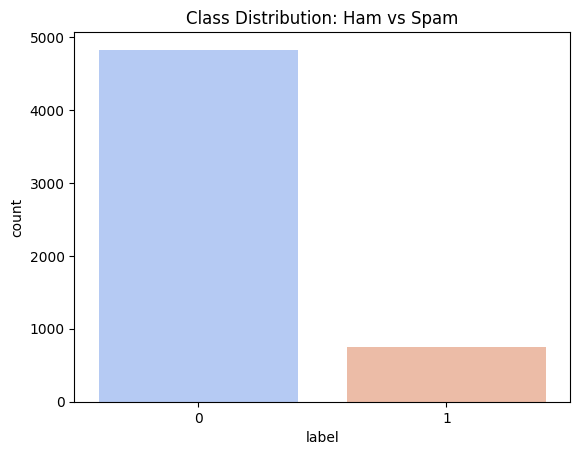

In [ ]:
# Plot spam vs. ham count
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df['label'], palette="coolwarm")
plt.title("Class Distribution: Ham vs Spam")
plt.show()


In [ ]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]  #Removing the stop words
    return " ".join(words)
df['clean_text'] = df['text'].apply(preprocess_text)


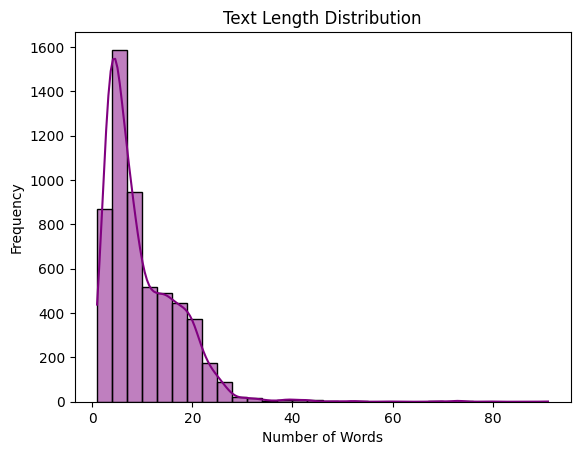

In [ ]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
# Plot text length distribution
sns.histplot(df['text_length'], bins=30, kde=True, color="purple")
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [ ]:
vectorizer = CountVectorizer(max_features=5000)  # Bag-of-Words model
X = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
# Create DataLoaders
BATCH_SIZE = 32
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class FNN_TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FNN_TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        output = self.sigmoid(self.fc2(hidden))
        return output


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = 256
OUTPUT_DIM = 1  # Binary classification
model = FNN_TextClassifier(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    model.train()

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()

        predictions = model(texts).squeeze(1)  # Ensure predictions is [batch_size]
        loss = criterion(predictions, labels.squeeze(1))  # Ensure labels is [batch_size]

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}')



Epoch [1/5], Loss: 33.1802
Epoch [2/5], Loss: 4.5150
Epoch [3/5], Loss: 1.6768
Epoch [4/5], Loss: 0.7902
Epoch [5/5], Loss: 0.4567


In [ ]:
## INFERENCE:
It can be seen through the 5 epochs that the loss is decresing over the epoch and epoch which means the model is improving its performance ...
Technically the weights are adjusted accordingly so that the loss will decrese.


In [ ]:
def evaluate(model, dataloader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)
            rounded_preds = torch.round(predictions)  # Convert probabilities to 0 or 1
            correct += (rounded_preds == labels.squeeze(1)).sum().item()
            total += labels.size(0)

    accuracy = (correct / total) * 100  # Ensure percentage calculation is correct
    return accuracy

# Check accuracy again
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 98.12%


In [ ]:
##This accuracy is too much.....which actually means the model is working well...

In [ ]:
#checking for overfitting
#nak dbt ostundi intha ekuva accuracy ochesthe
#dhani kosam test accuracy and training accuracy ni compare cheyali
def calculate_accuracy(y_pred, y_true):
    y_pred = (y_pred >= 0.5).float()  # Convert probabilities to binary labels (0 or 1)
    correct = (y_pred == y_true).sum().item()
    return correct / y_true.shape[0] * 100  # Percentage accuracy


CALCULATE TRAINING ACCURACY

In [ ]:
# Training Loop
model.train()
train_correct = 0
train_total = 0

for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    optimizer.zero_grad()
    y_pred = model(X_batch)
    loss = criterion(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    train_correct += (y_pred.round() == y_batch).sum().item()
    train_total += y_batch.size(0)

train_accuracy = train_correct / train_total * 100
print(f"Training Accuracy: {train_accuracy:.2f}%")


Training Accuracy: 99.98%


In [ ]:
# Evaluation on Test Set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():  # No gradient calculation needed for evaluation
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        test_correct += (y_pred.round() == y_batch).sum().item()
        test_total += y_batch.size(0)

test_accuracy = test_correct / test_total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 98.03%


In [ ]:
##both training and test accuracy are very close, the model is performing well